In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from IPython.display import clear_output

import experiment

from grid import Grid
from SIR import SIR

# Exp01: Baseline
In this short experiment we compare the mathematical model with the cellular automata implementation of the SIR model. In the CA model, we consider all cells neighbours during the updating of cell states. In theory this should make the two models equivalent. Since the CA model is a simulation, we average the results of 10 runs and compare that to the mathematical model. 

In [31]:
# General settings
simulations = 10        # Number of simulations for the CA Model.
size  = (32, 32)        # Population of the simulations.
gamma = 1 / 10          # Recovery rate. 
beta  = 0.25            # Infection rate. Number of contacts * chance to infect.
model = 'SIR'           # Which model to use

## Mathematical Model

In [61]:
# Settings
N = size[0] * size[1]
R_0 = beta / gamma

# Run the model
MM_results = SIR(N, R_0, gamma, 1, 750, model)
MM_results = pd.DataFrame.from_dict(MM_results)
for c in model:
    MM_results[f'd{c}'] = MM_results[c].diff()
MM_results['dI'] = MM_results['dI'] + MM_results['dR']
MM_results['R_t'] = MM_results['dI'] / MM_results['dR']
MM_results['Timestep'] = MM_results.index

## Cellular Automata Model

In [24]:
# Prepare list to store results
CAM_results = []

# Simulate 10 runs
for i in range(simulations):
    results = Grid.simulate(size[0],
                            size[1],
                            verbose=True,
                            beta=beta,
                            gamma=gamma,
                            infected=1,
                            neighbours='all',
                            nr_of_neighbours=20,
                            )
    results = pd.DataFrame.from_dict(results)
    results['Sim'] = i + 1
    CAM_results.append(results)

# Clear output
clear_output()

In [64]:
# Make all dataframes the same length
longest = max([len(df) for df in CAM_results])
updated = []
for df in CAM_results:
    df = df.append(df.iloc[[-1]*(longest - len(df))]).reset_index()
    for c in model:
        df[f'd{c}'] = df[c].diff().fillna(0)
    df['dI'] = df['dI'] + df['dR']
    df['R_t'] = df['dI'] / df['dR'].replace(0, 1)
    df['Timestep'] = df.index
    updated.append(df)

# Merge results in one dataframe
CAM_results_post_proc = pd.concat(updated).sort_values(by=['Timestep'])

## Results

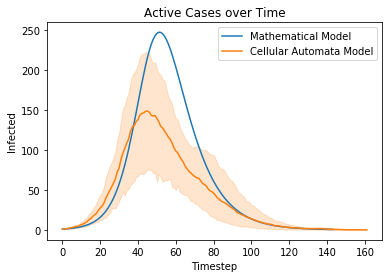

In [44]:
# Plot results
sns.lineplot(x='Timestep', y='I', data=MM_results, label='Mathematical Model')
sns.lineplot(x='Timestep', y='I', data=CAM_results_post_proc, label='Cellular Automata Model')
plt.ylabel('Infected')
plt.title('Active Cases over Time')
plt.show()

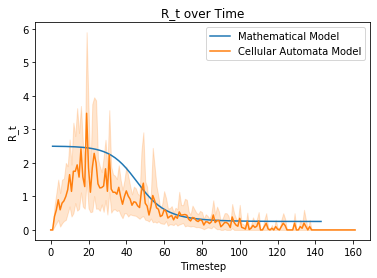

In [66]:
# Plot results
sns.lineplot(x='Timestep', y='R_t', data=MM_results, label='Mathematical Model')
sns.lineplot(x='Timestep', y='R_t', data=CAM_results_post_proc, label='Cellular Automata Model')
plt.ylabel('R_t')
plt.title('R_t over Time')
plt.show()

<a id="exp02"></a>
# Exp02: Scalability
Use an initial setting, say:
simulation = 10;
gamma = .10;
beta = 0.25.

_because it is quickly to much i.e. too long, lets take max three round of 10, 15, 20, 25, 30 and make a plot of the average runtime vs gridsize_

In [15]:
# General settings
simulations = 10                # Number of simulations for the CA Model.
sizes = [10, 15, 20, 25, 30]    # The different population sizes to compare.
gamma = 1 / 10                  # Recovery rate. 
beta  = 0.25                    # Infection rate. Number of contacts * chance to infect.

## Mathematical Model

In [16]:
# Settings
R_0 = beta / gamma

# Prepare output
MM_outputs = {k: [] for k in sizes}

# Run the model
for s in sizes:

    # Compute population
    N = s * s

    # Run model
    MM_results = SIR(N, R_0, gamma, 1, 750, 'SIR')
    MM_results = pd.DataFrame.from_dict(MM_results)
    MM_results['Sim'] = 1
    MM_results['Timestep'] = MM_results.index

    # Store results
    MM_outputs[s] = MM_results

## Cellular Automata Model

In [18]:
# Prepare list to store results
CAM_outputs = {k: [] for k in sizes}

# Run the model
for s in sizes:

    # Simulate 10 runs
    for i in range(simulations):
        results = Grid.simulate(s,
                                s,
                                verbose=True,
                                beta=beta,
                                gamma=gamma,
                                infected=1,
                                neighbours='all',
                                nr_of_neighbours=20,
                                )
        results = pd.DataFrame.from_dict(results)
        results['Sim'] = i + 1
        CAM_outputs[s].append(results)

# Clear output
clear_output()

In [19]:
for k, results in CAM_outputs.items():
    # Make all dataframes the same length
    longest = max([len(df) for df in results])
    updated = []
    for df in results:
        df = df.append(df.iloc[[-1]*(longest - len(df))]).reset_index()
        df['Timestep'] = df.index
        updated.append(df)

    # Merge results in one dataframe
    CAM_outputs[k] = pd.concat(updated).sort_values(by=['Timestep'])

## Results

In [20]:
def total_infected(output):
    """ Returns the total % of the population affected over the pandemic. """
    tot_infected = {k: sim.groupby('Sim').apply(lambda x: x['R'].iloc[-1]) / (k*k) for k, sim in output.items()}
    tot_infected = pd.concat(tot_infected).reset_index()
    tot_infected.columns = ['Size', 'Sim', 'Tot_R']
    tot_infected['Pop'] = tot_infected['Size'] ** 2
    return tot_infected

def max_infected(output):
    """ Returns the max % of the population affected at once. """
    max_inf = {k: sim.groupby('Sim')['I'].max() / (k*k) for k, sim in output.items()}
    max_inf = pd.concat(max_inf).reset_index()
    max_inf.columns = ['Size', 'Sim', 'Max_R']
    max_inf['Pop'] = max_inf['Size'] ** 2
    return max_inf

def total_duration(output):
    """ Returns the duration of the pandemic. """
    dur = {k: sim.groupby('Sim').apply(lambda x: x[x['I']<0.5]['Timestep'].min()) for k, sim in output.items()}
    dur = pd.concat(dur).reset_index()
    dur.columns = ['Size', 'Sim', 'Duration']
    dur['Pop'] = dur['Size'] ** 2
    return dur

def comp_metrics(output):
    """ Returns a dataframe containing metrics. """
    tot_inf = total_infected(output)
    max_inf = max_infected(output)
    duration = total_duration(output)
    return pd.merge(pd.merge(tot_inf, max_inf), duration)

Text(0.5, 1.0, 'Duration of the Pandemic')

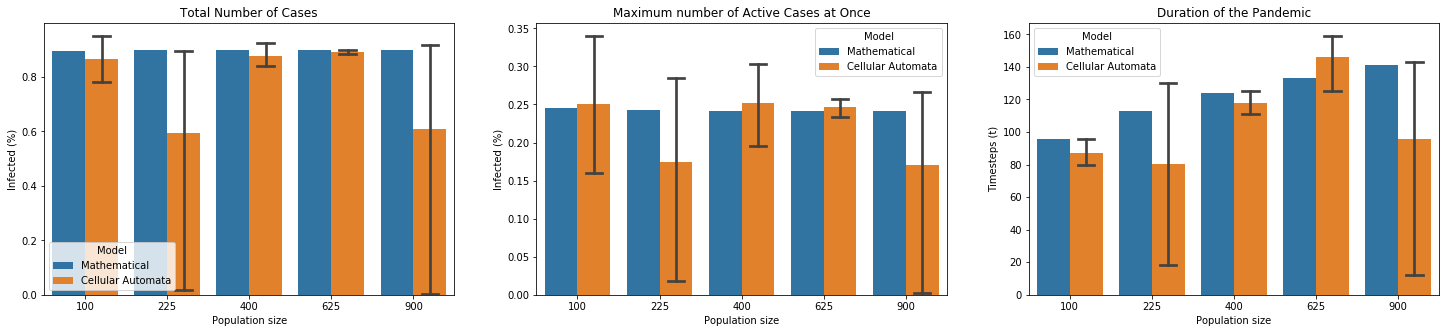

In [21]:
# Compute metrics
MM_metrics = comp_metrics(MM_outputs)
CAM_metrics = comp_metrics(CAM_outputs)

# Add model as variable
MM_metrics['Model'] = 'Mathematical'
CAM_metrics['Model'] = 'Cellular Automata'

# Merge models
metrics = pd.concat((MM_metrics, CAM_metrics)).reset_index()

# Plot figures
fig, axs = plt.subplots(ncols=3, figsize=(25, 5))
sns.barplot(x="Pop", y="Tot_R", hue="Model", data=metrics, capsize=0.2, ax=axs[0])
axs[0].set_xlabel('Population size')
axs[0].set_ylabel('Infected (%)')
axs[0].set_title('Total Number of Cases')
sns.barplot(x="Pop", y="Max_R", hue="Model", data=metrics, capsize=0.2, ax=axs[1])
axs[1].set_xlabel('Population size')
axs[1].set_ylabel('Infected (%)')
axs[1].set_title('Maximum number of Active Cases at Once')
sns.barplot(x="Pop", y="Duration", hue="Model", data=metrics, capsize=0.2, ax=axs[2])
axs[2].set_xlabel('Population size')
axs[2].set_ylabel('Timesteps (t)')
axs[2].set_title('Duration of the Pandemic')

# Exp03: Neighbour selection

In [103]:
# General settings
simulations = 10                            # Number of simulations for the CA Model.
size  = 25                                  # The different population sizes to compare.
R     = 2.5                                 # Reproduction rate. 
beta  = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] # Infection rate. Number of contacts * chance to infect.
neig  = [8, 32, 64, 128, 256]               # Number of neighbours to consider.
radii = [1, 4, 8, 12, 16]                   # Radii to use

## Metrics

In [105]:
def total_infected(output, var='Variable', pop=625):
    """ Returns the total % of the population affected over the pandemic. """
    tot_infected = {k: sim.groupby('Sim').apply(lambda x: x['R'].iloc[-1]) / pop * 100 for k, sim in output.items()}
    tot_infected = pd.concat(tot_infected).reset_index()
    tot_infected.columns = [var, 'Sim', 'Tot_R']
    return tot_infected

def max_infected(output, var='Variable', pop=625):
    """ Returns the max % of the population affected at once. """
    max_inf = {k: sim.groupby('Sim')['I'].max() / pop * 100 for k, sim in output.items()}
    max_inf = pd.concat(max_inf).reset_index()
    max_inf.columns = [var, 'Sim', 'Max_R']
    return max_inf

def total_duration(output, var='Variable'):
    """ Returns the duration of the pandemic. """
    dur = {k: sim.groupby('Sim').apply(lambda x: x[x['I']<0.5]['Timestep'].min()) for k, sim in output.items()}
    dur = pd.concat(dur).reset_index()
    dur.columns = [var, 'Sim', 'Duration']
    return dur

def comp_metrics(output, var='Variable', pop=625):
    """ Returns a dataframe containing metrics. """
    tot_inf = total_infected(output, var, pop)
    max_inf = max_infected(output, var, pop)
    duration = total_duration(output, var)
    return pd.merge(pd.merge(tot_inf, max_inf), duration)

## Mathematical model

In [109]:
# Prepare output
MM_beta = {k: [] for k in beta}
MM_neig = {k: [] for k in neig}

# Run the model
for b in beta:

    # Settings
    gamma = b / R

    # Compute population
    N = size ** 2

    # Run model
    MM_results = SIR(N, R, gamma, 1, 750, 'SIR')
    MM_results = pd.DataFrame.from_dict(MM_results)
    MM_results['Sim'] = 1
    MM_results['Timestep'] = MM_results.index

    # Store results
    MM_beta[b] = MM_results

# Run the model
for n in neig:

    # Settings
    gamma = 0.5 / R

    # Compute population
    N = size ** 2

    # Run model
    MM_results = SIR(N, 2.5, gamma, 1, 750, 'SIR')
    MM_results = pd.DataFrame.from_dict(MM_results)
    MM_results['Sim'] = 1
    MM_results['Timestep'] = MM_results.index

    # Store results
    MM_neig[n] = MM_results

# Compute metrics
MM_beta_met = comp_metrics(MM_beta, 'Beta', 625)
MM_neig_met = comp_metrics(MM_neig, 'Neighbours', 625)

# Add model value
MM_beta_met['Model'] = 'Mathematical'
MM_neig_met['Model'] = 'Mathematical'

## Neighbours: all

In [87]:
# Prepare list to store results
CAM_beta = {k: [] for k in beta}
CAM_neig = {k: [] for k in neig}

# Run the model
for b in beta:

    # Comput gamme
    gamma = b / R

    # Simulate 10 runs
    for i in range(simulations):
        results = Grid.simulate(size,
                                size,
                                verbose=True,
                                beta=b,
                                gamma=gamma,
                                infected=1,
                                neighbours='all',
                                nr_of_neighbours=64,
                                )
        results = pd.DataFrame.from_dict(results)
        results['Sim'] = i + 1
        CAM_beta[b].append(results)

for k, results in CAM_beta.items():
    # Make all dataframes the same length
    longest = max([len(df) for df in results])
    updated = []
    for df in results:
        df = df.append(df.iloc[[-1]*(longest - len(df))]).reset_index()
        df['Timestep'] = df.index
        updated.append(df)

    # Merge results in one dataframe
    CAM_beta[k] = pd.concat(updated).sort_values(by=['Timestep'])

# Clear output
clear_output()

# Run the model
for n in neig:

    # Simulate 10 runs
    for i in range(simulations):
        results = Grid.simulate(size,
                                size,
                                verbose=True,
                                beta=0.5,
                                gamma=0.1,
                                infected=1,
                                neighbours='all',
                                nr_of_neighbours=n,
                                )
        results = pd.DataFrame.from_dict(results)
        results['Sim'] = i + 1
        CAM_neig[n].append(results)

for k, results in CAM_neig.items():
    # Make all dataframes the same length
    longest = max([len(df) for df in results])
    updated = []
    for df in results:
        df = df.append(df.iloc[[-1]*(longest - len(df))]).reset_index()
        df['Timestep'] = df.index
        updated.append(df)

    # Merge results in one dataframe
    CAM_neig[k] = pd.concat(updated).sort_values(by=['Timestep'])

# Clear output
clear_output()

## Results

Text(0.5, 1.0, 'Duration of the Pandemic')

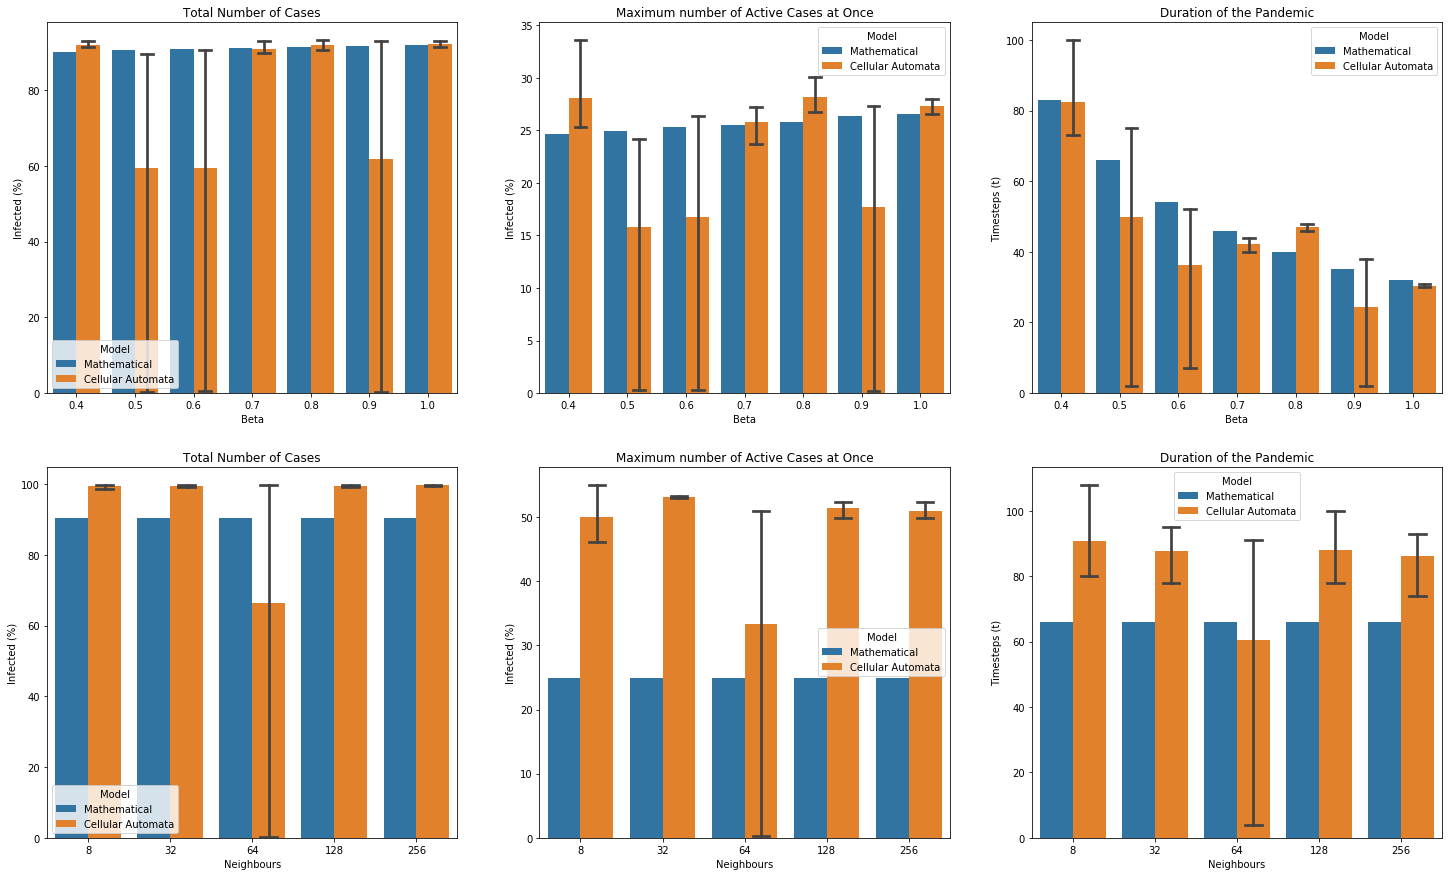

In [100]:
# Compute metrics
CAM_beta_met = comp_metrics(CAM_beta, 'Beta', 625)
CAM_neig_met = comp_metrics(CAM_neig, 'Neighbours', 625)

# Add model as variable
CAM_beta_met['Model'] = 'Cellular Automata'
CAM_neig_met['Model'] = 'Cellular Automata'

# Merge models
beta_metrics = pd.concat((MM_beta_met, CAM_beta_met)).reset_index()
neig_metrics = pd.concat((MM_neig_met, CAM_neig_met)).reset_index()

# Plot figures
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(25, 15))
sns.barplot(x="Beta", y="Tot_R", hue="Model", data=beta_metrics, capsize=0.2, ax=axs[0][0])
axs[0][0].set_xlabel('Beta')
axs[0][0].set_ylabel('Infected (%)')
axs[0][0].set_title('Total Number of Cases')
sns.barplot(x="Beta", y="Max_R", hue="Model", data=beta_metrics, capsize=0.2, ax=axs[0][1])
axs[0][1].set_xlabel('Beta')
axs[0][1].set_ylabel('Infected (%)')
axs[0][1].set_title('Maximum number of Active Cases at Once')
sns.barplot(x="Beta", y="Duration", hue="Model", data=beta_metrics, capsize=0.2, ax=axs[0][2])
axs[0][2].set_xlabel('Beta')
axs[0][2].set_ylabel('Timesteps (t)')
axs[0][2].set_title('Duration of the Pandemic')
sns.barplot(x="Neighbours", y="Tot_R", hue="Model", data=neig_metrics, capsize=0.2, ax=axs[1][0])
axs[1][0].set_xlabel('Neighbours')
axs[1][0].set_ylabel('Infected (%)')
axs[1][0].set_title('Total Number of Cases')
sns.barplot(x="Neighbours", y="Max_R", hue="Model", data=neig_metrics, capsize=0.2, ax=axs[1][1])
axs[1][1].set_xlabel('Neighbours')
axs[1][1].set_ylabel('Infected (%)')
axs[1][1].set_title('Maximum number of Active Cases at Once')
sns.barplot(x="Neighbours", y="Duration", hue="Model", data=neig_metrics, capsize=0.2, ax=axs[1][2])
axs[1][2].set_xlabel('Neighbours')
axs[1][2].set_ylabel('Timesteps (t)')
axs[1][2].set_title('Duration of the Pandemic')

## Neighbours: radius

In [ ]:
# Prepare list to store results
CAM_beta = {k: [] for k in beta}
CAM_neig = {k: [] for k in radii}

# Run the model
for b in beta:

    # Comput gamme
    gamma = b / R

    # Simulate 10 runs
    for i in range(simulations):
        results = Grid.simulate(size,
                                size,
                                verbose=True,
                                beta=b,
                                gamma=gamma,
                                infected=1,
                                neighbours='radius',
                                radius=8,
                                nr_of_neighbours=64,
                                )
        results = pd.DataFrame.from_dict(results)
        results['Sim'] = i + 1
        CAM_beta[b].append(results)

for k, results in CAM_beta.items():
    # Make all dataframes the same length
    longest = max([len(df) for df in results])
    updated = []
    for df in results:
        df = df.append(df.iloc[[-1]*(longest - len(df))]).reset_index()
        df['Timestep'] = df.index
        updated.append(df)

    # Merge results in one dataframe
    CAM_beta[k] = pd.concat(updated).sort_values(by=['Timestep'])

# Clear output
clear_output()

# Run the model
for r in radii:

    # Simulate 10 runs
    for i in range(simulations):
        results = Grid.simulate(size,
                                size,
                                verbose=True,
                                beta=0.5,
                                gamma=0.1,
                                infected=1,
                                neighbours='radius',
                                radius=8,
                                )
        results = pd.DataFrame.from_dict(results)
        results['Sim'] = i + 1
        CAM_neig[r].append(results)

for k, results in CAM_neig.items():
    # Make all dataframes the same length
    longest = max([len(df) for df in results])
    updated = []
    for df in results:
        df = df.append(df.iloc[[-1]*(longest - len(df))]).reset_index()
        df['Timestep'] = df.index
        updated.append(df)

    # Merge results in one dataframe
    CAM_neig[k] = pd.concat(updated).sort_values(by=['Timestep'])

# Clear output
clear_output()

## Results

In [ ]:
# Compute metrics
CAM_beta_met = comp_metrics(CAM_beta, 'Beta', 625)
CAM_neig_met = comp_metrics(CAM_neig, 'Neighbours', 625)

# Add model as variable
CAM_beta_met['Model'] = 'Cellular Automata'
CAM_neig_met['Model'] = 'Cellular Automata'

# Merge models
beta_metrics = pd.concat((MM_beta_met, CAM_beta_met)).reset_index()
neig_metrics = pd.concat((MM_neig_met, CAM_neig_met)).reset_index()

# Plot figures
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(25, 15))
sns.barplot(x="Beta", y="Tot_R", hue="Model", data=beta_metrics, capsize=0.2, ax=axs[0][0])
axs[0][0].set_xlabel('Beta')
axs[0][0].set_ylabel('Infected (%)')
axs[0][0].set_title('Total Number of Cases')
sns.barplot(x="Beta", y="Max_R", hue="Model", data=beta_metrics, capsize=0.2, ax=axs[0][1])
axs[0][1].set_xlabel('Beta')
axs[0][1].set_ylabel('Infected (%)')
axs[0][1].set_title('Maximum number of Active Cases at Once')
sns.barplot(x="Beta", y="Duration", hue="Model", data=beta_metrics, capsize=0.2, ax=axs[0][2])
axs[0][2].set_xlabel('Beta')
axs[0][2].set_ylabel('Timesteps (t)')
axs[0][2].set_title('Duration of the Pandemic')
sns.barplot(x="Neighbours", y="Tot_R", hue="Model", data=neig_metrics, capsize=0.2, ax=axs[1][0])
axs[1][0].set_xlabel('Neighbours')
axs[1][0].set_ylabel('Infected (%)')
axs[1][0].set_title('Total Number of Cases')
sns.barplot(x="Neighbours", y="Max_R", hue="Model", data=neig_metrics, capsize=0.2, ax=axs[1][1])
axs[1][1].set_xlabel('Neighbours')
axs[1][1].set_ylabel('Infected (%)')
axs[1][1].set_title('Maximum number of Active Cases at Once')
sns.barplot(x="Neighbours", y="Duration", hue="Model", data=neig_metrics, capsize=0.2, ax=axs[1][2])
axs[1][2].set_xlabel('Neighbours')
axs[1][2].set_ylabel('Timesteps (t)')
axs[1][2].set_title('Duration of the Pandemic')

## Neighbours: random

In [ ]:
# Prepare list to store results
CAM_beta = {k: [] for k in beta}
CAM_neig = {k: [] for k in neig}

# Run the model
for b in beta:

    # Comput gamme
    gamma = b / R

    # Simulate 10 runs
    for i in range(simulations):
        results = Grid.simulate(size,
                                size,
                                verbose=True,
                                beta=b,
                                gamma=gamma,
                                infected=1,
                                neighbours='random',
                                nr_of_neighbours=64,
                                )
        results = pd.DataFrame.from_dict(results)
        results['Sim'] = i + 1
        CAM_beta[b].append(results)

for k, results in CAM_beta.items():
    # Make all dataframes the same length
    longest = max([len(df) for df in results])
    updated = []
    for df in results:
        df = df.append(df.iloc[[-1]*(longest - len(df))]).reset_index()
        df['Timestep'] = df.index
        updated.append(df)

    # Merge results in one dataframe
    CAM_beta[k] = pd.concat(updated).sort_values(by=['Timestep'])

# Clear output
clear_output()

# Run the model
for n in neig:

    # Simulate 10 runs
    for i in range(simulations):
        results = Grid.simulate(size,
                                size,
                                verbose=True,
                                beta=0.5,
                                gamma=0.1,
                                infected=1,
                                neighbours='random',
                                nr_of_neighbours=n,
                                )
        results = pd.DataFrame.from_dict(results)
        results['Sim'] = i + 1
        CAM_neig[n].append(results)

for k, results in CAM_neig.items():
    # Make all dataframes the same length
    longest = max([len(df) for df in results])
    updated = []
    for df in results:
        df = df.append(df.iloc[[-1]*(longest - len(df))]).reset_index()
        df['Timestep'] = df.index
        updated.append(df)

    # Merge results in one dataframe
    CAM_neig[k] = pd.concat(updated).sort_values(by=['Timestep'])

# Clear output
clear_output()

## Results

In [ ]:
# Compute metrics
CAM_beta_met = comp_metrics(CAM_beta, 'Beta', 625)
CAM_neig_met = comp_metrics(CAM_neig, 'Neighbours', 625)

# Add model as variable
CAM_beta_met['Model'] = 'Cellular Automata'
CAM_neig_met['Model'] = 'Cellular Automata'

# Merge models
beta_metrics = pd.concat((MM_beta_met, CAM_beta_met)).reset_index()
neig_metrics = pd.concat((MM_neig_met, CAM_neig_met)).reset_index()

# Plot figures
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(25, 15))
sns.barplot(x="Beta", y="Tot_R", hue="Model", data=beta_metrics, capsize=0.2, ax=axs[0][0])
axs[0][0].set_xlabel('Beta')
axs[0][0].set_ylabel('Infected (%)')
axs[0][0].set_title('Total Number of Cases')
sns.barplot(x="Beta", y="Max_R", hue="Model", data=beta_metrics, capsize=0.2, ax=axs[0][1])
axs[0][1].set_xlabel('Beta')
axs[0][1].set_ylabel('Infected (%)')
axs[0][1].set_title('Maximum number of Active Cases at Once')
sns.barplot(x="Beta", y="Duration", hue="Model", data=beta_metrics, capsize=0.2, ax=axs[0][2])
axs[0][2].set_xlabel('Beta')
axs[0][2].set_ylabel('Timesteps (t)')
axs[0][2].set_title('Duration of the Pandemic')
sns.barplot(x="Neighbours", y="Tot_R", hue="Model", data=neig_metrics, capsize=0.2, ax=axs[1][0])
axs[1][0].set_xlabel('Neighbours')
axs[1][0].set_ylabel('Infected (%)')
axs[1][0].set_title('Total Number of Cases')
sns.barplot(x="Neighbours", y="Max_R", hue="Model", data=neig_metrics, capsize=0.2, ax=axs[1][1])
axs[1][1].set_xlabel('Neighbours')
axs[1][1].set_ylabel('Infected (%)')
axs[1][1].set_title('Maximum number of Active Cases at Once')
sns.barplot(x="Neighbours", y="Duration", hue="Model", data=neig_metrics, capsize=0.2, ax=axs[1][2])
axs[1][2].set_xlabel('Neighbours')
axs[1][2].set_ylabel('Timesteps (t)')
axs[1][2].set_title('Duration of the Pandemic')

## Neighbours: gauss

In [ ]:
# Prepare list to store results
CAM_beta = {k: [] for k in beta}
CAM_neig = {k: [] for k in neig}

# Run the model
for b in beta:

    # Comput gamme
    gamma = b / R

    # Simulate 10 runs
    for i in range(simulations):
        results = Grid.simulate(size,
                                size,
                                verbose=True,
                                beta=b,
                                gamma=gamma,
                                infected=1,
                                neighbours='gauss',
                                SD=5,
                                nr_of_neighbours=64,
                                )
        results = pd.DataFrame.from_dict(results)
        results['Sim'] = i + 1
        CAM_beta[b].append(results)

for k, results in CAM_beta.items():
    # Make all dataframes the same length
    longest = max([len(df) for df in results])
    updated = []
    for df in results:
        df = df.append(df.iloc[[-1]*(longest - len(df))]).reset_index()
        df['Timestep'] = df.index
        updated.append(df)

    # Merge results in one dataframe
    CAM_beta[k] = pd.concat(updated).sort_values(by=['Timestep'])

# Clear output
clear_output()

# Run the model
for n in neig:

    # Simulate 10 runs
    for i in range(simulations):
        results = Grid.simulate(size,
                                size,
                                verbose=True,
                                beta=0.5,
                                gamma=0.1,
                                infected=1,
                                neighbours='gauss',
                                SD=5,
                                nr_of_neighbours=n,
                                )
        results = pd.DataFrame.from_dict(results)
        results['Sim'] = i + 1
        CAM_neig[n].append(results)

for k, results in CAM_neig.items():
    # Make all dataframes the same length
    longest = max([len(df) for df in results])
    updated = []
    for df in results:
        df = df.append(df.iloc[[-1]*(longest - len(df))]).reset_index()
        df['Timestep'] = df.index
        updated.append(df)

    # Merge results in one dataframe
    CAM_neig[k] = pd.concat(updated).sort_values(by=['Timestep'])

# Clear output
clear_output()

## Results

In [ ]:
# Compute metrics
CAM_beta_met = comp_metrics(CAM_beta, 'Beta', 625)
CAM_neig_met = comp_metrics(CAM_neig, 'Neighbours', 625)

# Add model as variable
CAM_beta_met['Model'] = 'Cellular Automata'
CAM_neig_met['Model'] = 'Cellular Automata'

# Merge models
beta_metrics = pd.concat((MM_beta_met, CAM_beta_met)).reset_index()
neig_metrics = pd.concat((MM_neig_met, CAM_neig_met)).reset_index()

# Plot figures
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(25, 15))
sns.barplot(x="Beta", y="Tot_R", hue="Model", data=beta_metrics, capsize=0.2, ax=axs[0][0])
axs[0][0].set_xlabel('Beta')
axs[0][0].set_ylabel('Infected (%)')
axs[0][0].set_title('Total Number of Cases')
sns.barplot(x="Beta", y="Max_R", hue="Model", data=beta_metrics, capsize=0.2, ax=axs[0][1])
axs[0][1].set_xlabel('Beta')
axs[0][1].set_ylabel('Infected (%)')
axs[0][1].set_title('Maximum number of Active Cases at Once')
sns.barplot(x="Beta", y="Duration", hue="Model", data=beta_metrics, capsize=0.2, ax=axs[0][2])
axs[0][2].set_xlabel('Beta')
axs[0][2].set_ylabel('Timesteps (t)')
axs[0][2].set_title('Duration of the Pandemic')
sns.barplot(x="Neighbours", y="Tot_R", hue="Model", data=neig_metrics, capsize=0.2, ax=axs[1][0])
axs[1][0].set_xlabel('Neighbours')
axs[1][0].set_ylabel('Infected (%)')
axs[1][0].set_title('Total Number of Cases')
sns.barplot(x="Neighbours", y="Max_R", hue="Model", data=neig_metrics, capsize=0.2, ax=axs[1][1])
axs[1][1].set_xlabel('Neighbours')
axs[1][1].set_ylabel('Infected (%)')
axs[1][1].set_title('Maximum number of Active Cases at Once')
sns.barplot(x="Neighbours", y="Duration", hue="Model", data=neig_metrics, capsize=0.2, ax=axs[1][2])
axs[1][2].set_xlabel('Neighbours')
axs[1][2].set_ylabel('Timesteps (t)')
axs[1][2].set_title('Duration of the Pandemic')